# Prediction of time series with neural networks

Forecast model building on DNNs, RNNs, and CNNs. Example using synthetic data set.
Some code adapted from ungraded exercise in DeepLearning.AI course Sequences, Time Series and Prediction.

## Imports

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import csv

## Utilities

In [2]:
def plot_series(x, y, format="-", start=0, end=None, 
                title=None, xlabel=None, ylabel=None, legend=None ):
    """
    visualize time series data

    args:
      x (array of int) - contains values for x-axis
      y (array of int or tuple of arrays) - contains values for y-axis
      format (string) - line style when plotting graph
      start (int) - first time step to plot
      end (int) - last time step to plot
      title (string) - title of plot
      xlabel (string) - label for x-axis
      ylabel (string) - label for y-axis
      legend (list of strings) - legend for plot
    """

    #setup dimensions of graph figure
    plt.figure(figsize=(10, 6))
    
    #check if more than two series to plot
    if type(y) is tuple:

      #loop over y elements
      for y_curr in y:

        #plot x and current y values
        plt.plot(x[start:end], y_curr[start:end], format)

    else:
      #plot x and y values
      plt.plot(x[start:end], y[start:end], format)

    #label x-axis
    plt.xlabel(xlabel)

    #label y-axis
    plt.ylabel(ylabel)

    #set legend
    if legend:
      plt.legend(legend)

    #set title
    plt.title(title)

    #overlay grid on graph
    plt.grid(True)

    #draw graph on screen
    plt.show()

## Load data

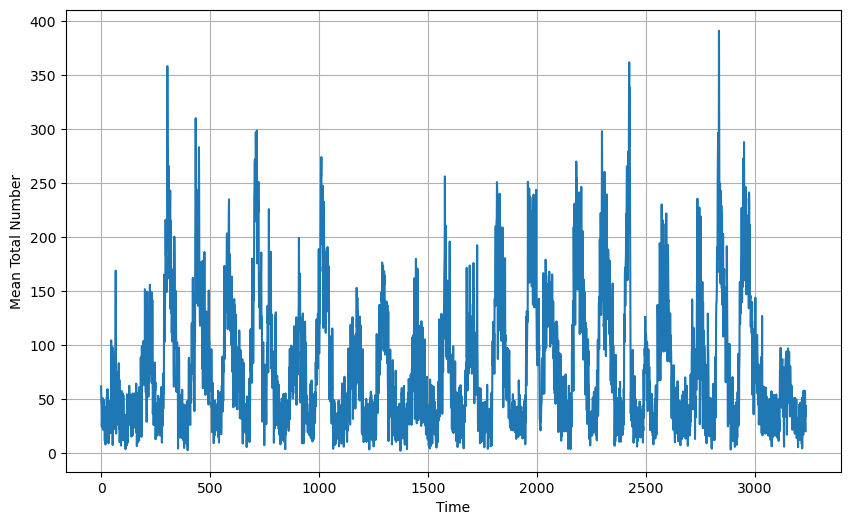

In [3]:
#initialize lists
time_step = []
timeseriesdata = []

#open csv file
with open('./timeseries_data1.csv') as csvfile:
  
  #initialize reader
  reader = csv.reader(csvfile, delimiter=',')
  
  #skip first line
  next(reader)
  
  #append row and time series number to lists
  for row in reader:
    time_step.append(int(row[0]))
    timeseriesdata.append(float(row[2]))

#convert lists to numpy arrays
time = np.array(time_step)
series = np.array(timeseriesdata)

#preview data
plot_series(time, series, xlabel='Time', ylabel='Mean Total Number')

## Split data set

In [4]:
#define split time
split_time = 3000

#get train set 
time_train = time[:split_time]
x_train = series[:split_time]

#get validation set
time_valid = time[split_time:]
x_valid = series[split_time:]

## Prepare features

In [5]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """generates data set windows

    args:
      series (array of float) - contains values of time series
      window_size (int) - number of time steps to include in feature
      batch_size (int) - batch size
      shuffle_buffer(int) - buffer size to use for shuffle method

    returns:
      dataset (TF data set) - TF data set containing time windows
    """
  
    #generate TF data set from series values
    dataset = tf.data.Dataset.from_tensor_slices(series)
    
    #window data but only take specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    
    #flatten windows in single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    #create tuples with features and labels 
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    #shuffle windows
    dataset = dataset.shuffle(shuffle_buffer)
    
    #create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    return dataset

## Set parameters

In [6]:
#parameters
window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

#generate data set windows
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

2024-04-25 20:41:14.728204: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-25 20:41:14.729490: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


## Build model

In [7]:
#build model
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=64, kernel_size=3,
                      strides=1,
                      activation="relu",
                      padding='causal',
                      input_shape=[window_size, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

#print model summary 
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 30, 64)            256       
                                                                 
 lstm (LSTM)                 (None, 30, 64)            33024     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 30)                1950      
                                                                 
 dense_1 (Dense)             (None, 10)                310       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
 lambda (Lambda)             (None, 1)                 0

## Tune learning rate

In [8]:
#get initial weights
init_weights = model.get_weights()

In [9]:
#set learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

#initialize optimizer
optimizer = tf.keras.optimizers.SGD(momentum=0.9)

#set training parameters
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

#train model
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
93/93 [==============================] - 5s 34ms/step - loss: 57.4079 - lr: 1.0000e-08
Epoch 2/100
93/93 [==============================] - 3s 28ms/step - loss: 46.4256 - lr: 1.1220e-08
Epoch 3/100
93/93 [==============================] - 3s 26ms/step - loss: 38.8412 - lr: 1.2589e-08
Epoch 4/100
93/93 [==============================] - 4s 36ms/step - loss: 35.3214 - lr: 1.4125e-08
Epoch 5/100
93/93 [==============================] - 4s 38ms/step - loss: 33.5380 - lr: 1.5849e-08
Epoch 6/100
93/93 [==============================] - 3s 28ms/step - loss: 32.3270 - lr: 1.7783e-08
Epoch 7/100
93/93 [==============================] - 3s 30ms/step - loss: 31.4000 - lr: 1.9953e-08
Epoch 8/100
93/93 [==============================] - 3s 32ms/step - loss: 30.5804 - lr: 2.2387e-08
Epoch 9/100
93/93 [==============================] - 3s 35ms/step - loss: 29.8647 - lr: 2.5119e-08
Epoch 10/100
93/93 [==============================] - 4s 37ms/step - loss: 29.1867 - lr: 2.8184e-08
Epoch 11/

93/93 [==============================] - 3s 35ms/step - loss: 31.5978 - lr: 1.2589e-04
Epoch 84/100
93/93 [==============================] - 4s 40ms/step - loss: 27.0748 - lr: 1.4125e-04
Epoch 85/100
93/93 [==============================] - 3s 36ms/step - loss: 27.1944 - lr: 1.5849e-04
Epoch 86/100
93/93 [==============================] - 3s 30ms/step - loss: 29.4733 - lr: 1.7783e-04
Epoch 87/100
93/93 [==============================] - 3s 30ms/step - loss: 36.4539 - lr: 1.9953e-04
Epoch 88/100
93/93 [==============================] - 3s 27ms/step - loss: 45.1271 - lr: 2.2387e-04
Epoch 89/100
93/93 [==============================] - 3s 28ms/step - loss: 50.1135 - lr: 2.5119e-04
Epoch 90/100
93/93 [==============================] - 3s 29ms/step - loss: 57.9769 - lr: 2.8184e-04
Epoch 91/100
93/93 [==============================] - 3s 29ms/step - loss: 51.1129 - lr: 3.1623e-04
Epoch 92/100
93/93 [==============================] - 3s 27ms/step - loss: 52.4928 - lr: 3.5481e-04
Epoch 93/100


(1e-08, 0.001, 0.0, 100.0)

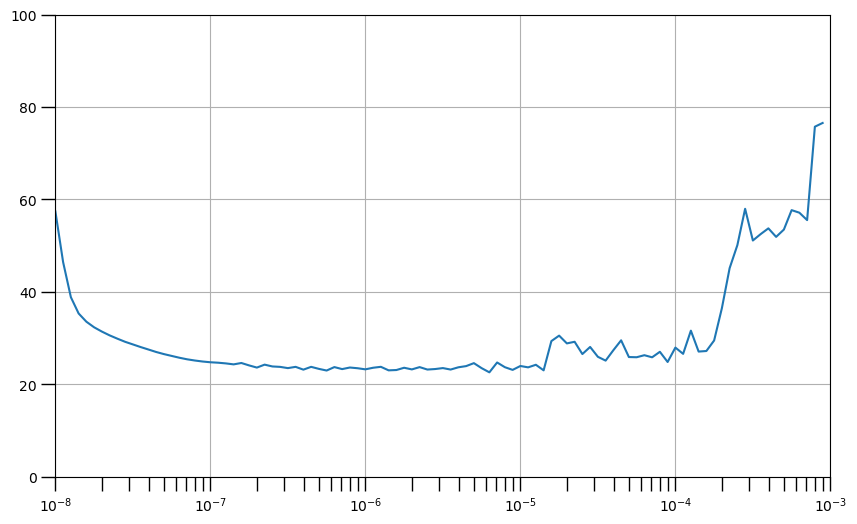

In [10]:
#define learning rate array
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

#set figure size
plt.figure(figsize=(10, 6))

#set grid
plt.grid(True)

#plot loss in log scale
plt.semilogx(lrs, history.history["loss"])

#increase tickmark size
plt.tick_params('both', length=10, width=1, which='both')

#set plot boundaries
plt.axis([1e-8, 1e-3, 0, 100])

## Train model

In [11]:
#reset states
tf.keras.backend.clear_session()

#reset weights
model.set_weights(init_weights)

In [12]:
#set learning rate
learning_rate = 10e-7 #for demonstration purposes, roughly good enough

#set optimizer 
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

#set training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [13]:
#train model
history = model.fit(train_set,epochs=500)

Epoch 1/500
93/93 [==============================] - 6s 37ms/step - loss: 31.0089 - mae: 31.5041
Epoch 2/500
93/93 [==============================] - 4s 37ms/step - loss: 25.1843 - mae: 25.6798
Epoch 3/500
93/93 [==============================] - 3s 27ms/step - loss: 24.1576 - mae: 24.6524
Epoch 4/500
93/93 [==============================] - 3s 26ms/step - loss: 24.8480 - mae: 25.3431
Epoch 5/500
93/93 [==============================] - 3s 29ms/step - loss: 24.0319 - mae: 24.5265
Epoch 6/500
93/93 [==============================] - 3s 35ms/step - loss: 23.7539 - mae: 24.2485
Epoch 7/500
93/93 [==============================] - 3s 27ms/step - loss: 23.6478 - mae: 24.1433
Epoch 8/500
93/93 [==============================] - 3s 33ms/step - loss: 22.8934 - mae: 23.3878
Epoch 9/500
93/93 [==============================] - 4s 36ms/step - loss: 23.1225 - mae: 23.6185
Epoch 10/500
93/93 [==============================] - 4s 41ms/step - loss: 22.6836 - mae: 23.1778
Epoch 11/500
93/93 [=========

93/93 [==============================] - 3s 31ms/step - loss: 21.1598 - mae: 21.6532
Epoch 168/500
93/93 [==============================] - 3s 32ms/step - loss: 21.0246 - mae: 21.5179
Epoch 169/500
93/93 [==============================] - 3s 31ms/step - loss: 21.1729 - mae: 21.6657
Epoch 170/500
93/93 [==============================] - 3s 36ms/step - loss: 21.0098 - mae: 21.5042
Epoch 171/500
93/93 [==============================] - 3s 34ms/step - loss: 21.1598 - mae: 21.6533
Epoch 172/500
93/93 [==============================] - 3s 32ms/step - loss: 21.1466 - mae: 21.6414
Epoch 173/500
93/93 [==============================] - 3s 27ms/step - loss: 21.0273 - mae: 21.5202
Epoch 174/500
93/93 [==============================] - 3s 28ms/step - loss: 21.2950 - mae: 21.7901
Epoch 175/500
93/93 [==============================] - 3s 32ms/step - loss: 20.9530 - mae: 21.4467
Epoch 176/500
93/93 [==============================] - 3s 27ms/step - loss: 21.0361 - mae: 21.5301
Epoch 177/500
93/93 [===

93/93 [==============================] - 3s 33ms/step - loss: 20.6798 - mae: 21.1723
Epoch 332/500
93/93 [==============================] - 3s 32ms/step - loss: 20.9805 - mae: 21.4744
Epoch 333/500
93/93 [==============================] - 3s 27ms/step - loss: 20.7902 - mae: 21.2844
Epoch 334/500
93/93 [==============================] - 3s 27ms/step - loss: 20.7738 - mae: 21.2683
Epoch 335/500
93/93 [==============================] - 3s 26ms/step - loss: 20.7122 - mae: 21.2059
Epoch 336/500
93/93 [==============================] - 2s 24ms/step - loss: 20.7277 - mae: 21.2214
Epoch 337/500
93/93 [==============================] - 4s 41ms/step - loss: 20.8301 - mae: 21.3246
Epoch 338/500
93/93 [==============================] - 3s 30ms/step - loss: 20.7376 - mae: 21.2302
Epoch 339/500
93/93 [==============================] - 3s 29ms/step - loss: 20.6652 - mae: 21.1581
Epoch 340/500
93/93 [==============================] - 2s 25ms/step - loss: 20.5904 - mae: 21.0841
Epoch 341/500
93/93 [===

93/93 [==============================] - 3s 33ms/step - loss: 20.4576 - mae: 20.9503
Epoch 496/500
93/93 [==============================] - 3s 27ms/step - loss: 20.4001 - mae: 20.8916
Epoch 497/500
93/93 [==============================] - 3s 26ms/step - loss: 20.2879 - mae: 20.7795
Epoch 498/500
93/93 [==============================] - 3s 31ms/step - loss: 20.2727 - mae: 20.7642
Epoch 499/500
93/93 [==============================] - 3s 35ms/step - loss: 20.2707 - mae: 20.7634
Epoch 500/500
93/93 [==============================] - 3s 33ms/step - loss: 20.3431 - mae: 20.8366


## Perform prediction

In [14]:
def model_forecast(model, series, window_size, batch_size):
    """uses an input model to generate predictions on data windows

    args:
      model (TF Keras model) - model that accepts data windows
      series (array of float) - contains values of time series
      window_size (int) - number of time steps to include in window
      batch_size (int) - batch size

    returns:
      forecast (numpy array) - array containing predictions
    """

    #generate TF data set from series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    #window data but only take specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    #flatten windows in single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    
    #create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    #get predictions on entire data set
    forecast = model.predict(dataset)
    
    return forecast

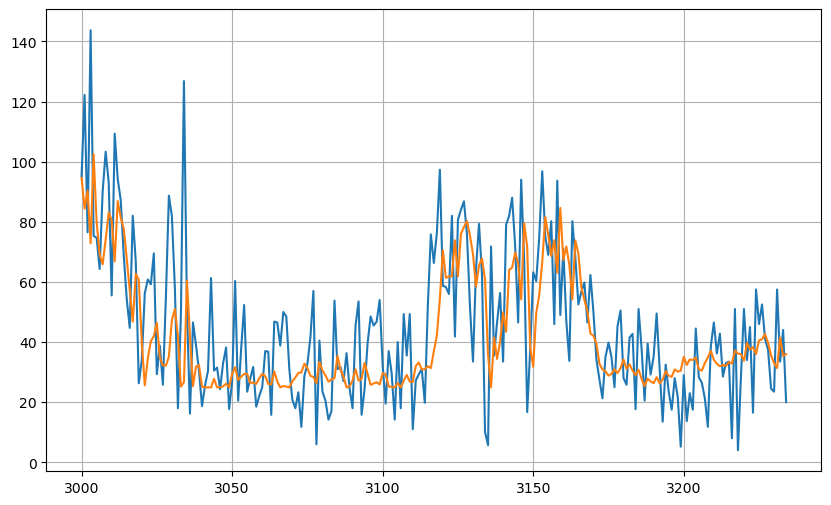

In [15]:
#reduce original series
forecast_series = series[split_time-window_size:-1]

#use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

#drop single dimensional axis
results = forecast.squeeze()

#plot results
plot_series(time_valid, (x_valid, results))

In [16]:
#compute mae
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

14.876139
